# The Cat Boost Notebook notebook

- The y-set for location A, B and C are concatonated (time index)
- The X-set for location A, B and C are concatonated (time index)
- One hot encoding for location and whether or not set is from the estimated column
- The y-set and the X-set are merged on date and location
- Having date features
- y-sets are normalized (MinMax)
- Removes repeated values in y-set B and C

It takes over from feature_engineering_1
Adds some ratio features from feature_engineering_3

**Takes over from cat_boost_2.ipynb**


Adds one feature, uses the same parameters


DID NOT WORK

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../C/X_test_estimated.parquet')

## Handling the Y-set

In [4]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True

    return sorted(intervals, key=lambda t: t[1] - t[0], reverse=True)

In [5]:
all_y = [train_a, train_b, train_c]
labels = ['A', 'B', 'C']

table = {}

i = 0
for y in all_y:
    loc, intervals = labels[i], find_repeated_rows(y)
    if isinstance(intervals[0], (int, float)):
        intervals = np.asarray(intervals, dtype=float)
    intervals = list(intervals) + [np.nan] * (1421 - len(intervals))
    table[loc] = intervals
    print("The largest interval for", loc, intervals[0])
    i += 1

table = pd.DataFrame(table)
table.head()

The largest interval for A (5176, 5218)
The largest interval for B (13409, 14466)
The largest interval for C (18105, 18727)


,A,B,C
0,"(5176, 5218)","(13409, 14466)","(18105, 18727)"
1,"(4526, 4547)","(19138, 20141)","(26048, 26669)"
2,"(22429, 22450)","(18690, 19137)","(27224, 27748)"
3,"(22933, 22954)","(10966, 11307)","(25400, 25876)"
4,"(67, 87)","(26115, 26353)","(10047, 10375)"


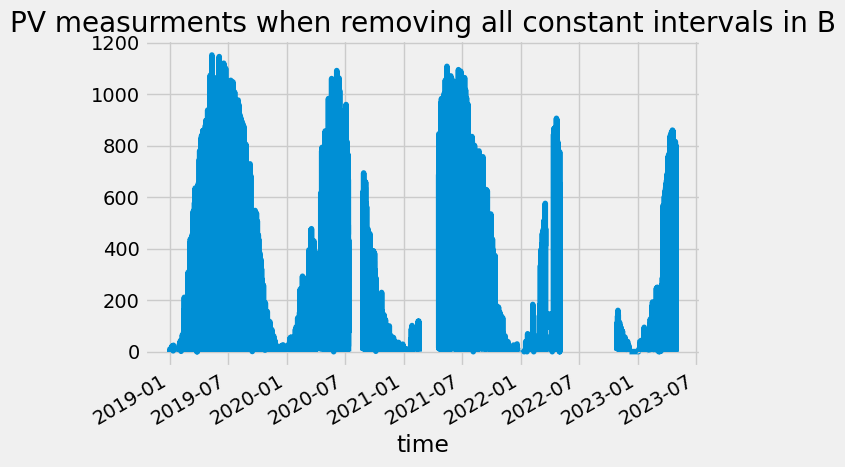

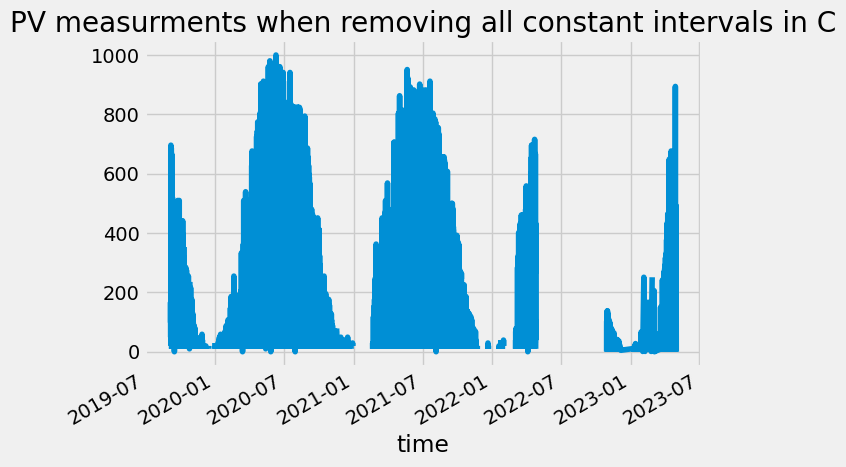

In [6]:
i = 1
for y in all_y[1:]:
    loc, intervals = labels[i], find_repeated_rows(y)
    for start, end in intervals:
        for row_index in range(start, end + 1):
            y.at[row_index, 'pv_measurement'] = np.nan

    test = y.set_index('time')
    test['pv_measurement'].plot(title="PV measurments when removing all constant intervals in " + loc)
    plt.show()
    i += 1

In [7]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

Normalizing values

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

In [9]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

In [10]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [11]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

,pv_measurement,location_A,location_B,location_C
time,,,,
2019-06-02 22:00:00,0.000000,1,0,0
2019-06-02 23:00:00,0.000000,1,0,0
2019-06-03 00:00:00,0.000000,1,0,0
2019-06-03 01:00:00,0.000000,1,0,0
2019-06-03 02:00:00,0.003377,1,0,0


Setting the index to **date_forecast** and resampling with mean.

In [12]:

X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_observed_a.drop("date_calc", axis=1, inplace=True)
X_train_observed_a = X_train_observed_a.resample('60min').median()


X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a = X_train_estimated_a.resample('60min').median()


X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_b:
    X_train_observed_b.drop("date_calc", axis=1, inplace=True)
X_train_observed_b = X_train_observed_b.resample('60min').median()


X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_b:
    X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b = X_train_estimated_b.resample('60min').median()


X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])
X_train_observed_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_c:
    X_train_observed_c.drop("date_calc", axis=1, inplace=True)
X_train_observed_c = X_train_observed_c.resample('60min').median()


X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])
X_train_estimated_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_c:
    X_train_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c = X_train_estimated_c.resample('60min').median()


In [13]:
X_train_observed_a.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10

In [14]:
f = 'air_density_2m:kgm3'

In [15]:
def replace_outliers_with_nan(df, feature):
    '''Replaces thr 0.01 and 0.99'''
    Q1 = df[feature].quantile(0.01)
    Q99 = df[feature].quantile(0.99)
    #median_value = df[feature].median()

    df[feature] = np.where(
        (df[feature] < Q1) | (df[feature] > Q99),
        np.nan,
        df[feature]
    )

In [16]:
outliers = ['air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa'
            
]

# 'air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa', 'wind_speed_10m:ms',
# 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms'

#0.04391554145075651

for o in outliers:
    replace_outliers_with_nan(X_train_observed_a, o)
    replace_outliers_with_nan(X_train_observed_b, o)
    replace_outliers_with_nan(X_train_observed_c, o)

In [17]:
#median = X_train_observed_a['air_density_2m:kgm3'].median()

#outliers_indices = (X_train_observed_a['air_density_2m:kgm3'] < 1.15) | (X_train_observed_a['air_density_2m:kgm3'] > 1.41)
#X_train_observed_a.loc[outliers_indices, 'air_density_2m:kgm3'] = np.nan
#X_train_observed_a['air_density_2m:kgm3'].interpolate(method='spline', order=3, inplace=True)
#X_train_observed_a[f].plot(style='o')

In [18]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location']= 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location']= 'C', 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1

In [19]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b,
               X_train_estimated_b, X_train_observed_c, X_train_estimated_c
               ], ignore_index=False)
X = X.sort_index()

One hot encoding on location

One hot encoding on location

In [20]:
# One hot encoding
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

In [21]:
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,date_calc
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,...,0.0,278.250000,87.500000,16823.399902,2.80,1.20,2.55,-0.0,0,NaT
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,...,0.0,278.349991,85.350002,16512.299805,2.90,1.10,2.65,-0.0,0,NaT
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,0.0,278.200012,99.099998,13277.399902,3.65,1.40,3.35,-0.0,0,NaT
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,0.0,278.100006,99.099998,12777.449707,3.55,1.50,3.20,-0.0,0,NaT
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,...,0.1,278.050003,97.849998,11142.549805,4.05,2.15,3.45,-0.0,0,NaT


In [22]:
def create_features(df):
    """
    Create Features
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    df['is_weekend'] = (df.index.weekday >= 5).astype(int)
    df['season'] = df.index.month.map(get_season)

    # Set a threshold for sun elevation (in degrees)
    elevation_threshold = 10  

    # Binary feature for significant sun elevation
    df['sun_above_threshold'] = (df['sun_elevation:d'] > elevation_threshold).astype(int)

    # Cosine and sine transformations of sun azimuth
    df['cos_sun_azimuth'] = np.cos(np.radians(df['sun_azimuth:d']))
    df['sin_sun_azimuth'] = np.sin(np.radians(df['sun_azimuth:d']))

    df['interaction_clear_sky_rad_sun_elevation'] = df['clear_sky_rad:W'] * df['sun_elevation:d']
    df['interaction_clear_sky_rad_effective_cloud_cover'] = df['clear_sky_rad:W'] * df['effective_cloud_cover:p']
    df['interaction_direct_rad_clear_sky'] = df['direct_rad:W'] * df['clear_sky_rad:W']

    df['ratio_clear_sky_rad_to_cloud_cover'] = df['clear_sky_rad:W'] / (df['effective_cloud_cover:p'] + 1e-8)  # added a small number to avoid division by zero

    df['ratio_direct_to_diffuse_rad'] = df['direct_rad:W'] / (df['diffuse_rad:W'] + 1e-8)

    df['ratio_air_density_to_humidity'] = df['air_density_2m:kgm3'] / (df['absolute_humidity_2m:gm3'] + 1e-8)

    df['ratio_wind_speed_10m_to_1000hPa'] = df['wind_speed_v_10m:ms'] / (df['wind_speed_w_1000hPa:ms'] + 1e-8)


    return df

def get_season(month):
    if 3 <= month <= 5:
        return 0  # spring
    elif 6 <= month <= 8:
        return 1  # summer
    elif 9 <= month <= 11:
        return 2  # fall
    else:
        return 3  # winter

df = create_features(df)

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,sun_above_threshold,cos_sun_azimuth,sin_sun_azimuth,interaction_clear_sky_rad_sun_elevation,interaction_clear_sky_rad_effective_cloud_cover,interaction_direct_rad_clear_sky,ratio_clear_sky_rad_to_cloud_cover,ratio_direct_to_diffuse_rad,ratio_air_density_to_humidity,ratio_wind_speed_10m_to_1000hPa
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,...,0,0.934996,0.354658,-0.0,0.0,0.0,0.0,0.0,0.223333,2.550000e+08
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,...,0,0.934934,0.354821,-0.0,0.0,0.0,0.0,0.0,0.227706,2.650000e+08
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,0,0.761584,0.648067,-0.0,0.0,0.0,0.0,0.0,0.231776,3.350000e+08
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,0,0.761815,0.647794,-0.0,0.0,0.0,0.0,0.0,0.229537,3.200000e+08
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,...,0,0.531894,0.846811,-0.0,0.0,0.0,0.0,0.0,0.229352,3.450000e+08


### Selecting features

Everything except:

- snow_density:kgm3
- cloud_base_agl:m
- ceiling_height_agl:m

They have a lot of NaN values.

In [23]:
FEATURES = [
    'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W',
    'dew_or_rime:idx', 'dew_point_2m:K',
    'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
    'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
    'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
    'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
    'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
    'snow_depth:cm', 'snow_drift:idx',
    'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
    'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
    'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
    'dayofmonth', 'weekofyear', 'is_weekend', 'season', 'sun_above_threshold',
    'cos_sun_azimuth', 'sin_sun_azimuth',
    'interaction_clear_sky_rad_effective_cloud_cover',
    'location_A', 'location_B', 'location_C', 'estimated'
]

TARGET = 'pv_measurement'

In [24]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [25]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]

df = df.dropna()
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

absolute_humidity_2m:gm3       72
air_density_2m:kgm3          1824
clear_sky_energy_1h:J          72
clear_sky_rad:W                72
dew_or_rime:idx                72
                            ...  
location_A                      0
location_B                      0
location_C                      0
estimated                       0
pv_measurement              43484
Length: 61, dtype: int64
absolute_humidity_2m:gm3    0
air_density_2m:kgm3         0
clear_sky_energy_1h:J       0
clear_sky_rad:W             0
dew_or_rime:idx             0
                           ..
location_A                  0
location_B                  0
location_C                  0
estimated                   0
pv_measurement              0
Length: 61, dtype: int64
DROPNA RESULTED IN 45327 ROWS BEING DROPPED. THE DATASET HAS 53759 ROWS IN TOTAL.


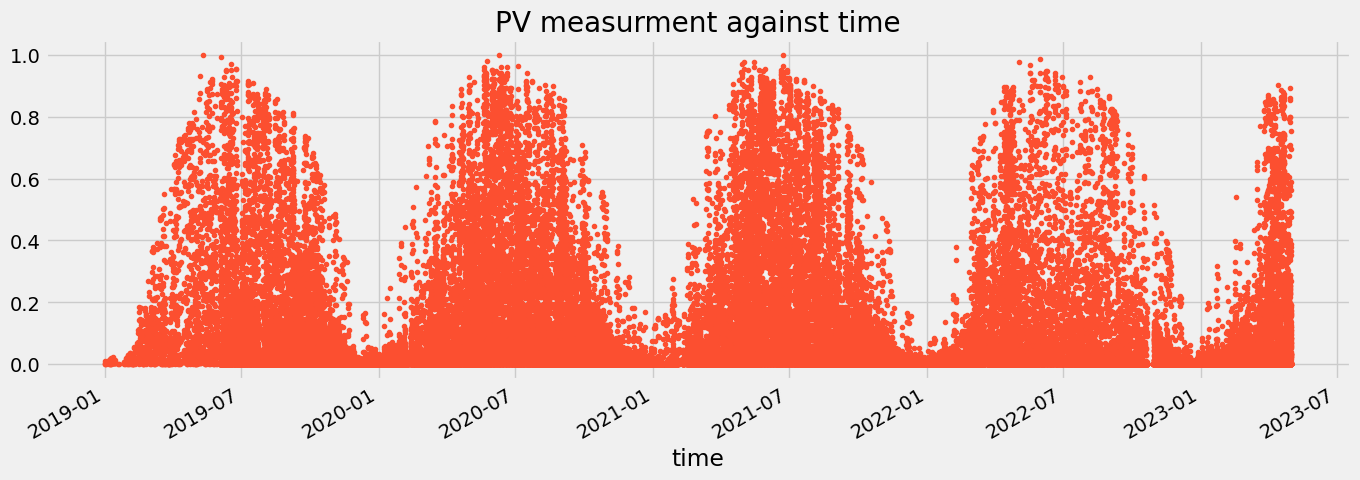

In [26]:
color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

### Preparing test data

- Excluding dates that should not be tested
- Including only the features we have defined

In [27]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)
    x_test.drop('date_calc', axis=1, inplace = True)
    x_test['estimated'] = 1

    x_test = x_test.resample('60min').median()

    x_test = create_features(x_test)

    if location == 'A':
        x_test['location_A'] =  1
        x_test['location_B'] = 0
        x_test['location_C'] = 0
    elif location == 'B':
        x_test['location_A'] =  0
        x_test['location_B'] = 1
        x_test['location_C'] = 0
    elif location == 'C':
        x_test['location_A'] =  0
        x_test['location_B'] = 0
        x_test['location_C'] = 1

    return x_test

In [28]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

In [29]:
test_sub = pd.read_csv('../../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())

In [30]:
x_test_a = x_test_a.loc[valid_dates]
x_test_b = x_test_b.loc[valid_dates]
x_test_c = x_test_c.loc[valid_dates]

In [31]:
X_test = pd.concat([x_test_a, x_test_b, x_test_c])
X_test = X_test[FEATURES]

### Disability Check

Check if the training data and the test data contains the same columns.

In [32]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")
    print("DIFFERENCE\n", X_test.columns.difference(check_train.columns))

EQUAL


Check if test data has the right amount of rows.

In [33]:
if X_test.shape[0] != 2160:
    print("X_test has wrong amount of rows!")
    print("Shape =", X_test.shape[0])
else:
    print("GOOD")

GOOD


In [34]:
X_train = df[FEATURES]
y_train = df[TARGET]

In [35]:
''' 
import optuna
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 500, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 1, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 100.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        'loss_function':'MAE'
    }

    if param["grow_policy"] == "Lossguide":
        param["max_leaves"] = trial.suggest_int("max_leaves", 31, 1024, log=True)



    cv_dataset = Pool(data=X_train, label=y_train)


    scores = cv(cv_dataset,
                    params=param,
                    fold_count=5,
                    plot=False,
                    type="TimeSeries",
                    verbose=False)
    

    # Extract the best score
    best_score = np.min(scores['test-MAE-mean'])
    
    return best_score
'''

' \nimport optuna\nfrom catboost import CatBoostRegressor, Pool, cv\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.model_selection import train_test_split\n\ndef objective(trial):\n    param = {\n        "iterations": trial.suggest_int("iterations", 500, 1500),\n        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),\n        "depth": trial.suggest_int("depth", 1, 16),\n        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),\n        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300),\n        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True),\n        "border_count": trial.suggest_int("border_count", 1, 255),\n        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0),\n        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 100.0),\n        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),\

In [36]:
#trials = 60

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=trials, n_jobs=-1, show_progress_bar=True)  

In [37]:
#best_params = study.best_params
#print('Best parameters:', best_params)

In [38]:
best_params = {
    'iterations': 854, 
    'learning_rate': 0.017432099489773544, 
    'depth': 14, 
    'colsample_bylevel': 0.43559465187532453,
    'min_data_in_leaf': 257,
    'l2_leaf_reg': 9.179321889625692, 
    'border_count': 129, 'random_strength': 0.8781261706316226, 
    'bagging_temperature': 11.599929150721326,
    'grow_policy': 'Lossguide',
    'max_leaves': 192
}

In [39]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(**best_params)
model.fit(X_train, y_train)


0:	learn: 0.2094013	total: 99.5ms	remaining: 1m 24s
1:	learn: 0.2065373	total: 159ms	remaining: 1m 7s
2:	learn: 0.2037332	total: 199ms	remaining: 56.5s
3:	learn: 0.2009697	total: 227ms	remaining: 48.3s
4:	learn: 0.1982901	total: 262ms	remaining: 44.4s
5:	learn: 0.1956637	total: 293ms	remaining: 41.5s
6:	learn: 0.1930728	total: 330ms	remaining: 39.9s
7:	learn: 0.1905223	total: 369ms	remaining: 39s
8:	learn: 0.1880081	total: 403ms	remaining: 37.8s
9:	learn: 0.1855245	total: 438ms	remaining: 36.9s
10:	learn: 0.1831277	total: 469ms	remaining: 36s
11:	learn: 0.1807491	total: 504ms	remaining: 35.3s
12:	learn: 0.1784327	total: 539ms	remaining: 34.9s
13:	learn: 0.1761883	total: 569ms	remaining: 34.1s
14:	learn: 0.1739685	total: 603ms	remaining: 33.7s
15:	learn: 0.1717839	total: 633ms	remaining: 33.2s
16:	learn: 0.1696330	total: 669ms	remaining: 32.9s
17:	learn: 0.1675352	total: 702ms	remaining: 32.6s
18:	learn: 0.1654596	total: 736ms	remaining: 32.4s
19:	learn: 0.1634460	total: 770ms	remaining

### Feature importance

In [40]:
feature_importances = model.get_feature_importance()
print("\nFeature Importances:\n")
for score, name in sorted(zip(feature_importances, X_train.columns), reverse=True):
    print(f'{name}: {score:.2f}')


Feature Importances:

direct_rad:W: 32.69
sun_elevation:d: 15.10
clear_sky_rad:W: 12.56
direct_rad_1h:J: 9.55
clear_sky_energy_1h:J: 6.68
diffuse_rad:W: 3.89
diffuse_rad_1h:J: 2.11
sun_above_threshold: 2.00
effective_cloud_cover:p: 1.82
visibility:m: 0.82
relative_humidity_1000hPa:p: 0.77
wind_speed_u_10m:ms: 0.68
elevation:m: 0.64
location_A: 0.60
dayofmonth: 0.55
interaction_clear_sky_rad_effective_cloud_cover: 0.53
total_cloud_cover:p: 0.49
t_1000hPa:K: 0.48
cos_sun_azimuth: 0.47
sin_sun_azimuth: 0.45
sun_azimuth:d: 0.44
dayofyear: 0.42
dew_point_2m:K: 0.40
year: 0.39
absolute_humidity_2m:gm3: 0.39
msl_pressure:hPa: 0.39
wind_speed_10m:ms: 0.38
wind_speed_v_10m:ms: 0.36
pressure_50m:hPa: 0.32
hour: 0.31
weekofyear: 0.30
snow_water:kgm2: 0.29
sfc_pressure:hPa: 0.29
pressure_100m:hPa: 0.29
air_density_2m:kgm3: 0.25
dayofweek: 0.23
precip_type_5min:idx: 0.22
is_in_shadow:idx: 0.18
month: 0.15
location_C: 0.14
fresh_snow_24h:cm: 0.14
precip_5min:mm: 0.14
location_B: 0.12
super_cooled_l

### Predict and make csv

In [41]:
predictions = model.predict(X_test)

In [42]:
predictions = pd.DataFrame(predictions, columns=['prediction'])

predictions.reset_index(drop=True, inplace=True)

predictions.head()

,prediction
0,0.000389
1,0.000297
2,0.000408
3,0.012107
4,0.075979


In [43]:
loc_a = predictions.iloc[:len(predictions)//3]
loc_b = predictions.iloc[len(predictions)//3:2*len(predictions)//3]
loc_c = predictions.iloc[2*len(predictions)//3:]

In [44]:

n = len(predictions)

# De-normalizing

loc_a.loc[:, 'prediction'] = scaler_a.inverse_transform(loc_a['prediction'].values.reshape(-1, 1))
loc_b.loc[:, 'prediction'] = scaler_b.inverse_transform(loc_b['prediction'].values.reshape(-1, 1))
loc_c.loc[:, 'prediction'] = scaler_c.inverse_transform(loc_c['prediction'].values.reshape(-1, 1))


In [45]:
predictions = pd.concat([loc_a, loc_b, loc_c])

In [46]:
predictions.head(10)

,prediction
0,2.227808
1,1.703540
2,2.338018
3,69.415525
4,435.621420
5,908.898441
6,1825.220798
7,2989.303227
8,3095.831555
9,3137.047881


In [47]:
predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.to_csv('predictions.csv', index=False)

Remove negative values

In [48]:
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0
predictions.to_csv('predictions.csv', index=False)

Redifing the training sets

In [49]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

### Plotting A

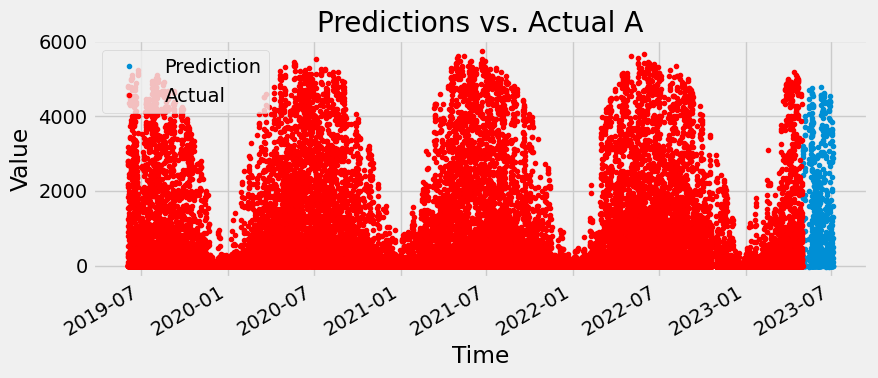

In [50]:
loc_a.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_a['prediction'].plot(style='.', label='Prediction')
train_a['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual A')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### Plotting B

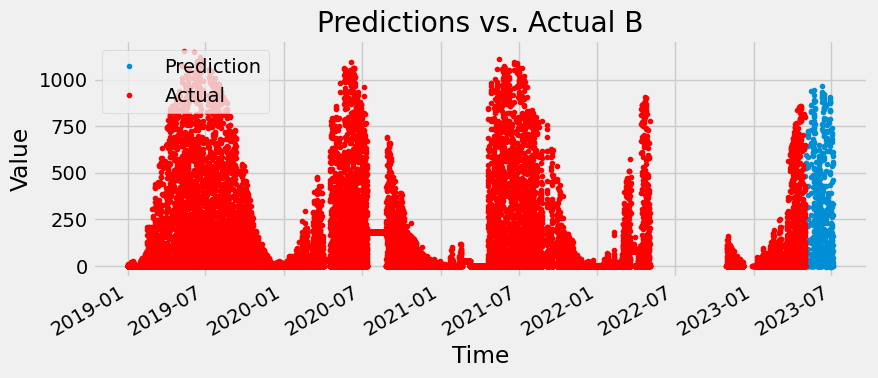

In [51]:
loc_b.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_b['prediction'].plot(style='.', label='Prediction')
train_b['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual B')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


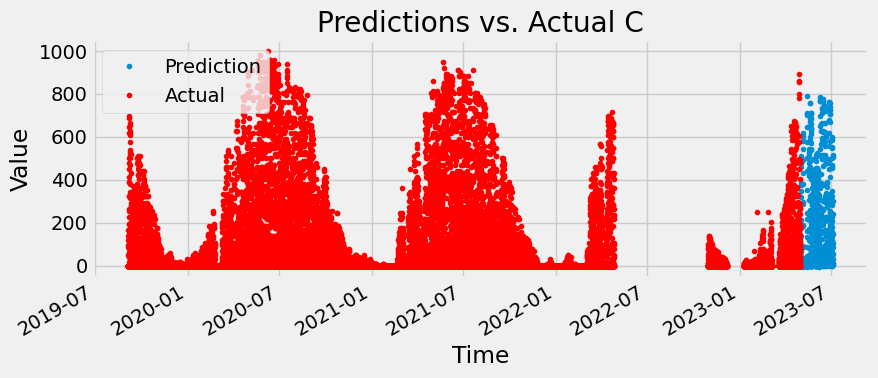

In [52]:
loc_c.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_c['prediction'].plot(style='.', label='Prediction')
train_c['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual C')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

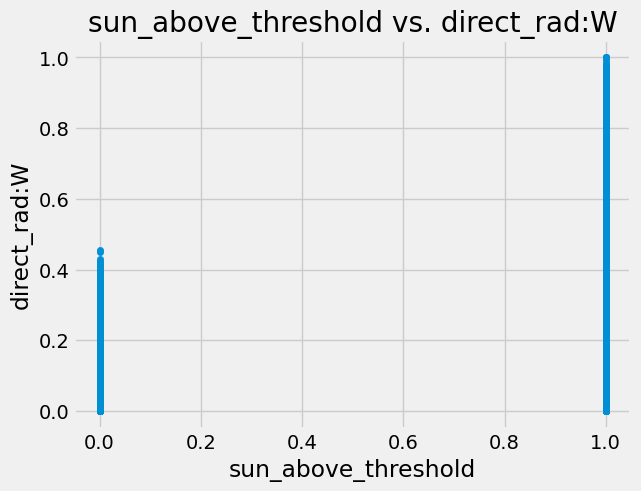

In [53]:
df.plot(x='sun_above_threshold', y='pv_measurement', kind='scatter')
plt.xlabel('sun_above_threshold')
plt.ylabel('direct_rad:W')
plt.title('sun_above_threshold vs. direct_rad:W')
plt.show()